In [9]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras import backend as K

In [4]:
class AutoLSTM():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
 
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0

    
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
    
    # convert series to supervised learning
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True, if_target=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        df_without_target = df.loc[:, df.columns[1:]]
        cols, names = list(), list()
        if if_target:
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        else:
            for i in range(n_in, 0, -1):
                cols.append(df_without_target.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(1, n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    

    def run(self, pred_begin_date, n, use_target=False, lags=3, leads=1): 
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''

        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(self.data)
        # flatten data
        reframed = self.series_to_supervised(scaled, lags, leads, True, use_target)
        # drop columns we don't want to predict
        reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
        reframed.drop(reframed.columns[range(reframed.shape[1] - 1 - (leads - 1) * (self.n_features + 1), reframed.shape[1]-1)], axis=1, inplace=True)

        values = reframed.values
        self.n = n

        test_date_begin = self.data.index.get_loc(pred_begin_date) - lags

        train = values[:test_date_begin, :]
        test = values[test_date_begin: test_date_begin+self.n, :]


        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.1))
        model.add(Dense(1))
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        model.compile(optimizer='adam', loss=root_mean_squared_error)
        
        result = model.fit(train_X, train_y, verbose=0, validation_data=(test_X, test_y), epochs=25, batch_size=72)
        self.model = model
        self.train_result = result
        
        pred_y = self.model.predict(test_X)

        # reverse standardization
        #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        # invert scaling for forecast
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        pred_y = pred_y.reshape((len(pred_y), 1))

        inv_yhat = np.concatenate((pred_y, test_X[:, 1:self.n_features+1]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual

        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, 1:self.n_features+1]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)

        df_result = pd.DataFrame(inv_yhat, columns=[self.target + '_pred'])
        df_result[self.target] = inv_y

        ### TODO modify range

        df_result['Date'] = self.data.index[test_date_begin + lags:  test_date_begin+lags+n]
        df_result.set_index(['Date'],inplace=True)

        self.df_result = df_result
        self.rmse = round(rmse,2)

Test RMSE: 335.277


<AxesSubplot:xlabel='Date'>

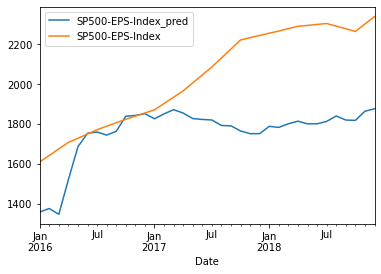

In [6]:
lstm_model = AutoLSTM(data_name='interaction_data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
d = '2016-01-01 00:00:00'
n = 36
lag = 12
lead = 12
lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
lstm_model.df_result.plot()

Test RMSE: 307.898


<AxesSubplot:xlabel='Date'>

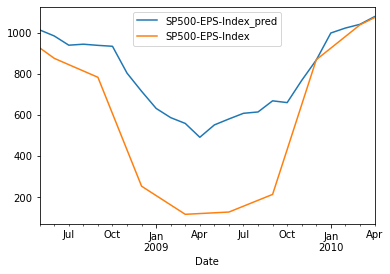

In [111]:
lstm_model = AutoLSTM(data_name='test.xlsx', target_name='SP500-EPS-Index', drop_cols=['GovernmentBudgetBalance'])
d = '2008-05-01 00:00:00'
n = 24
l = 1
lstm_model.run(pred_begin_date=d, n=n, include_target=True, lags=l)
lstm_model.df_result.plot()

## cross validation

In [17]:
# lags = [12, 15, 18, 21, 24, 27, 30]
# leadings = np.arange(1, 25)

# lstm_model = AutoLSTM(data_name='interaction_data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
# d = '2016-01-01 00:00:00'
# n = 36
# results = {}

for lead in leadings:
    results[lead] = []
    for lag in lags:
        print(f'lead: {lead}, lag: {lag}')
        rmse_temp = []
        lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
        rmse_temp.append(lstm_model.rmse)
        lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
        rmse_temp.append(lstm_model.rmse)
        lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
        rmse_temp.append(lstm_model.rmse)

        results[lead].append(np.average(rmse_temp))


lead: 1, lag: 12
Test RMSE: 107.440
Test RMSE: 86.718
Test RMSE: 101.593
lead: 1, lag: 15
Test RMSE: 120.606
Test RMSE: 126.774
Test RMSE: 130.806
lead: 1, lag: 18
Test RMSE: 180.846
Test RMSE: 169.627
Test RMSE: 175.670
lead: 1, lag: 21
Test RMSE: 157.790
Test RMSE: 199.400
Test RMSE: 189.326
lead: 1, lag: 24
Test RMSE: 217.090
Test RMSE: 207.000
Test RMSE: 257.959
lead: 1, lag: 27
Test RMSE: 258.279
Test RMSE: 301.469
Test RMSE: 249.544
lead: 1, lag: 30
Test RMSE: 190.084
Test RMSE: 197.657
Test RMSE: 264.047
lead: 2, lag: 12
Test RMSE: 131.718
Test RMSE: 108.607
Test RMSE: 117.591
lead: 2, lag: 15
Test RMSE: 130.782
Test RMSE: 167.382
Test RMSE: 151.230
lead: 2, lag: 18
Test RMSE: 157.786
Test RMSE: 243.084
Test RMSE: 209.929
lead: 2, lag: 21
Test RMSE: 258.498
Test RMSE: 186.835
Test RMSE: 214.203
lead: 2, lag: 24
Test RMSE: 208.818
Test RMSE: 209.784
Test RMSE: 195.583
lead: 2, lag: 27
Test RMSE: 206.369
Test RMSE: 237.623
Test RMSE: 219.955
lead: 2, lag: 30
Test RMSE: 256.581
Tes

ValueError: Length of values (36) does not match length of index (35)

In [23]:
rmse_temp = []
n = 24
lead=24
for lag in lags:
    print(f'lead: {lead}, lag: {lag}')
    rmse_temp = []
    lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
    rmse_temp.append(lstm_model.rmse)
    lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
    rmse_temp.append(lstm_model.rmse)
    lstm_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
    rmse_temp.append(lstm_model.rmse)

    results[lead].append(np.average(rmse_temp))

lead: 24, lag: 12
Test RMSE: 447.398
Test RMSE: 450.830
Test RMSE: 449.441
lead: 24, lag: 15
Test RMSE: 441.975
Test RMSE: 389.351
Test RMSE: 515.786
lead: 24, lag: 18
Test RMSE: 469.323
Test RMSE: 646.752
Test RMSE: 369.111
lead: 24, lag: 21
Test RMSE: 438.638
Test RMSE: 493.472
Test RMSE: 501.944
lead: 24, lag: 24
Test RMSE: 435.389
Test RMSE: 633.374
Test RMSE: 480.124
lead: 24, lag: 27
Test RMSE: 459.554
Test RMSE: 417.421
Test RMSE: 525.579
lead: 24, lag: 30
Test RMSE: 486.822
Test RMSE: 508.238
Test RMSE: 298.501


In [26]:
cv_lstm = pd.DataFrame(results)

In [30]:
lags

[12, 15, 18, 21, 24, 27, 30]

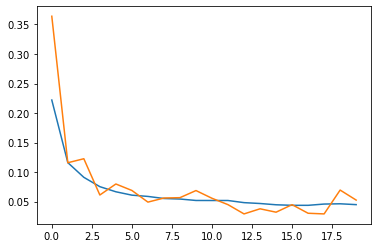

In [53]:
plt.plot(lstm_model.train_result.history['loss'])
plt.plot(lstm_model.train_result.history['val_loss'])

In [105]:
lags = np.arange(1, 20, 1)
result_withtarget = []

d = '2015-01-01 00:00:00'
n = 24

for la in lags:
    print(f'lags {la}')
    lstm_model.run(pred_begin_date=d, n=n, include_target=True, lags=la)
    result_withtarget.append(lstm_model.rmse)


lags 1
Test RMSE: 44.840
lags 2
Test RMSE: 75.841
lags 3
Test RMSE: 74.746
lags 4
Test RMSE: 77.658
lags 5
Test RMSE: 86.387
lags 6
Test RMSE: 84.318
lags 7
Test RMSE: 106.227
lags 8
Test RMSE: 144.109
lags 9
Test RMSE: 196.663
lags 10
Test RMSE: 64.052
lags 11
Test RMSE: 97.631
lags 12
Test RMSE: 42.977
lags 13
Test RMSE: 50.557
lags 14
Test RMSE: 68.006
lags 15
Test RMSE: 87.040
lags 16
Test RMSE: 79.187
lags 17
Test RMSE: 63.408
lags 18
Test RMSE: 101.166
lags 19
Test RMSE: 60.775


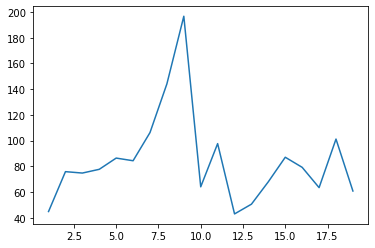

In [108]:
plt.plot(lags,result_withtarget)

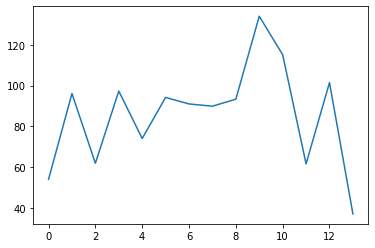

In [104]:
plt.plot(result_withtarget)

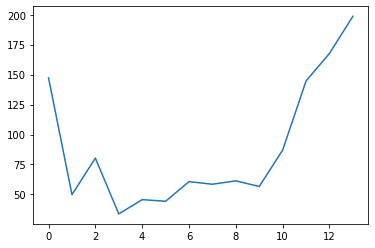

In [102]:
plt.plot(result_withtarget)

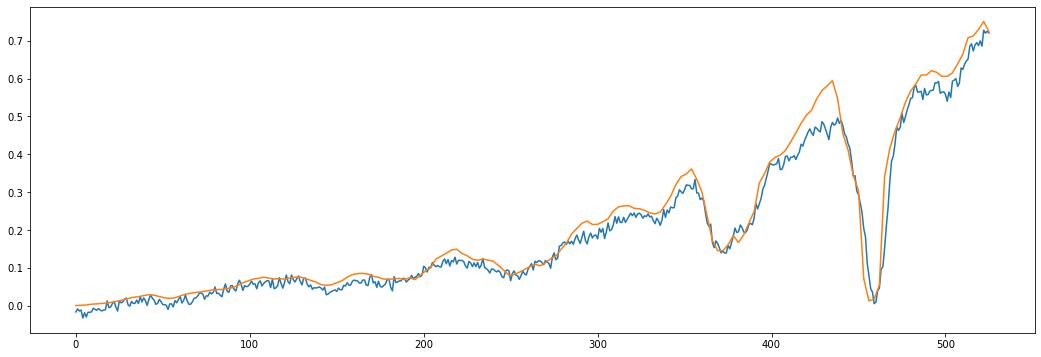

In [110]:
train_y_pred = lstm_model.model.predict(lstm_model.train_X)

plt.figure(figsize=(18, 6))
plt.plot(train_y_pred)
plt.plot(lstm_model.train_y)

In [32]:
window_data = lstm_model.series_to_supervised(lstm_model.data, l, 1, True, False)
window_data.drop(window_data.columns[range(window_data.shape[1] - lstm_model.n_features, window_data.shape[1])], axis=1, inplace=True)

values = window_data.values

d2 = '2016-10-01 00:00:00'
n2 = 48
test_date_begin = lstm_model.data.index.get_loc(d2) - l

train = values[:test_date_begin, :]
test = values[test_date_begin: test_date_begin+n2, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
test_y_pred = lstm_model.model.predict(test_X)


In [39]:
curr_path = os.getcwd()
input_path = os.path.join(curr_path, 'data_1107.xlsx')
data = pd.read_excel(input_path, index_col=0)

In [27]:
from scipy.signal import argrelextrema

def preprocess(dataset):
        ilocs_min = argrelextrema(dataset['SP500-EPS-Index'].values, np.less_equal, mode = 'wrap', order = 12)[0]
        ilocs_max = argrelextrema(dataset['SP500-EPS-Index'].values, np.greater_equal, mode = 'wrap', order = 12)[0]
        
        # encode expanding period as 1, contracting period as 0
        is_expanding = []
        i = 0
        is_expanding.extend(np.repeat(1, ilocs_min[i]))

        while i < len(ilocs_min) - 1:
            num_expanding = ilocs_max[i] - ilocs_min[i]
            num_contracting = ilocs_min[i + 1] - ilocs_max[i]
            is_expanding.extend(np.repeat(0, num_expanding))
            is_expanding.extend(np.repeat(1, num_contracting))
            i += 1

        is_expanding.extend(np.repeat(0, ilocs_max[i] - ilocs_min[i]))
        is_expanding.extend(np.repeat(1, dataset.shape[0] - ilocs_max[i]))
        dataset.insert(0, 'IsContracting', is_expanding)
        return dataset

In [41]:
preprocess(data)

,IsContracting,SP500-EPS-Index,ActivityIndex,NewOrders,Shipments,UnfilledOrders,DeliveryTime,Inventories,PricesPaid,Employment,AverageWorkweek,GS10,M2,GovernmentBudgetBalance
Date,,,,,,,,,,,,,,
1969-08-01,1,100.000000,8.0,16.9,31.1,0.1,-5.4,3.9,38.2,2.0,2.6,6.69,578.4,-5.624
1969-09-01,1,100.287869,-1.6,6.2,6.9,-4.1,-3.6,6.5,41.2,7.1,3.4,7.16,581.3,-5.624
1969-10-01,1,99.682710,12.1,3.0,11.6,-20.1,-5.8,-2.5,35.3,3.8,4.8,7.10,583.7,-5.624
1969-11-01,1,99.067314,-3.4,7.5,5.0,-5.7,-0.9,3.9,35.9,5.6,-2.0,7.14,584.8,-3.466
1969-12-01,1,98.459021,-7.9,9.6,23.2,-15.5,-7.8,-5.0,37.3,2.3,1.4,7.65,590.1,-3.466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1,NaN,30.7,22.2,27.2,22.5,29.3,17.9,80.7,30.7,20.1,NaN,NaN,NaN
2021-07-01,1,NaN,21.9,17.0,24.6,19.0,33.3,-4.0,69.7,29.2,18.4,NaN,NaN,NaN
2021-08-01,1,NaN,19.4,22.8,18.9,7.0,26.3,-18.1,71.2,32.6,24.5,NaN,NaN,NaN


In [49]:
data.columns

Index(['IsContracting', 'SP500-EPS-Index', 'ActivityIndex', 'NewOrders',
       'Shipments', 'UnfilledOrders', 'DeliveryTime', 'Inventories',
       'PricesPaid', 'Employment', 'AverageWorkweek', 'GS10', 'M2',
       'GovernmentBudgetBalance', 'IsExpanding', 'ActivityIndex_contract',
       'NewOrders_contract', 'Shipments_contract', 'UnfilledOrders_contract',
       'DeliveryTime_contract', 'Inventories_contract', 'PricesPaid_contract',
       'Employment_contract', 'AverageWorkweek_contract', 'GS10_contract',
       'M2_contract', 'GovernmentBudgetBalance_contract',
       'ActivityIndex_expand', 'NewOrders_expand', 'Shipments_expand',
       'UnfilledOrders_expand', 'DeliveryTime_expand', 'Inventories_expand',
       'PricesPaid_expand', 'Employment_expand', 'AverageWorkweek_expand',
       'GS10_expand', 'M2_expand', 'GovernmentBudgetBalance_expand'],
      dtype='object')

In [43]:
inter_columns = ['ActivityIndex', 'NewOrders','Shipments', 'UnfilledOrders', 'DeliveryTime', 'Inventories','PricesPaid', 'Employment', 'AverageWorkweek', 'GS10', 'M2','GovernmentBudgetBalance']

In [44]:
data['IsExpanding'] = 1-data['IsContracting']

In [46]:
for col in inter_columns:
    col_name = col + '_contract'
    data[col_name] = data['IsContracting']*data[col]

In [48]:
for col in inter_columns:
    col_name = col + '_expand'
    data[col_name] = data['IsExpanding']*data[col]

In [50]:
data.drop(inter_columns,axis = 1, inplace=True)

In [52]:
data.drop(['IsContracting', 'IsExpanding'], axis=1, inplace=True)

In [59]:
data['AverageWorkweek_contract'].values

array([  2.6,   3.4,   4.8,  -2. ,   1.4,   3. ,  -4. ,  -7.1,  -7.1,
       -25.8,   7.6,  -2. ,  -7.8,  11.7, -10. ,  -6.5,   0. ,  -0. ,
        -0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,
         0. ,  -0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,   0. ,   0. ,
         0. ,  -0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,  -0. ,  -0. ,  -0. ,  -0. ,   2.6, -12.5,
       -18. , -32.5, -23.4, -20.7, -21.8, -21.5, -14.8,  -5.8,  -8.7,
        -1.3,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,   0. ,
        -0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,   0. ,
         0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,  -0. ,  -0. ,
        -0. ,  -7.7,

In [60]:
data.to_excel('interaction_data_1107.xlsx', index=False)